1. **"As is" transfer learning** is when you take a pretrained model as it is and apply it to your task without any changes.
For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).

  This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with "/classification" in their name on TensorFlow Hub provide this kind of functionality.
2. **Feature extraction transfer learning** is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.
For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that only the top few layers become trainable, the rest remain frozen.

  This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.
3. **Fine-tuning transfer learning** is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.

  This usually means training some, many or all of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.
  <img width=100% src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-different-kinds-of-transfer-learning.png"/>

In [1]:
!nvidia-smi

Wed May  3 11:02:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import zipfile

!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"

zip_file = zipfile.ZipFile("10_food_classes_10_percent.zip", 'r')
zip_file.extractall()
zip_file.close()

--2023-05-03 11:05:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.96.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  39.8MB/s    in 4.8s    

2023-05-03 11:05:59 (33.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [10]:
import os
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'): 
  if len(filenames) != 0:   
    print(f"{len(filenames)} files in directory '{dirpath.split('/')[-1] if dirpath.split('/')[-2] == 'train' else (dirpath.split('/')[-2]+'/'+dirpath.split('/')[-1])}'")

75 files in directory 'grilled_salmon'
75 files in directory 'ice_cream'
75 files in directory 'steak'
75 files in directory 'ramen'
75 files in directory 'sushi'
75 files in directory 'fried_rice'
75 files in directory 'chicken_curry'
75 files in directory 'hamburger'
75 files in directory 'chicken_wings'
75 files in directory 'pizza'
250 files in directory 'test/grilled_salmon'
250 files in directory 'test/ice_cream'
250 files in directory 'test/steak'
250 files in directory 'test/ramen'
250 files in directory 'test/sushi'
250 files in directory 'test/fried_rice'
250 files in directory 'test/chicken_curry'
250 files in directory 'test/hamburger'
250 files in directory 'test/chicken_wings'
250 files in directory 'test/pizza'


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = "10_food_classes_10_percent/train"
test_data_dir = "10_food_classes_10_percent/test"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_data_dir,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode="categorical"
)

test_data = test_datagen.flow_from_directory(
    test_data_dir,
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode="categorical"
)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [21]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [18]:
import datetime
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Takes a directory name and an experiment name to create a TensorBoard callback object.

  Args:
    dir_name (str): The name of the directory that will be used for the created files.
    experiment_name (str): The name of the experiment we are running. Experiments with
      the same name will gathered under the same parent folder.

  Returns:
    A TensorBoard callback object initialized with the target directory and the name of the experiment.
  """

  log_dir = ''.join([dir_name, '/', experiment_name, '/', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")])
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [13]:
import tensorflow_hub as hub

resnet_v2_50_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_b0_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [14]:
def create_transferl_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URl and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to the number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes outputs.
  """
  feature_extractor_layer = hub.KerasLayer(
      model_url,
      trainable=False,
      name="feature_extractor_layer",
      input_shape=IMG_SIZE+(3,)
  )

  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(units=num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [15]:
resnet_model = create_transferl_model(resnet_v2_50_url, train_data.num_classes)
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
    loss=tf.keras.losses.CategoricalCrossentropy()
)
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
efficientnet_model = create_transferl_model(efficientnet_b0_url,train_data.num_classes)
efficientnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
    loss=tf.keras.losses.CategoricalCrossentropy()
)
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [19]:
resnet_history = resnet_model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps=len(test_data),
    callbacks=[
        create_tensorboard_callback('tensorflow_hub', 'resnet50V2')
    ]
)

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230503-122038
Epoch 1/5
24/24 [==============================] - 40s 1s/step - loss: 2.0821 - accuracy: 0.3213 - val_loss: 1.2454 - val_accuracy: 0.6052
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 0.9549 - accuracy: 0.7160 - val_loss: 0.8749 - val_accuracy: 0.7148
Epoch 3/5
24/24 [==============================] - 22s 945ms/step - loss: 0.6458 - accuracy: 0.8173 - val_loss: 0.7537 - val_accuracy: 0.7568
Epoch 4/5
24/24 [==============================] - 18s 785ms/step - loss: 0.4927 - accuracy: 0.8720 - val_loss: 0.7232 - val_accuracy: 0.7668
Epoch 5/5
24/24 [==============================] - 18s 776ms/step - loss: 0.3920 - accuracy: 0.9080 - val_loss: 0.6780 - val_accuracy: 0.7816


In [20]:
efficientnet_history = efficientnet_model.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps=len(test_data),
    callbacks=[
        create_tensorboard_callback('tensorflow_hub', 'efficientB0')
    ]
)

Saving TensorBoard log files to: tensorflow_hub/efficientB0/20230503-122300
Epoch 1/5
24/24 [==============================] - 37s 1s/step - loss: 1.8933 - accuracy: 0.4320 - val_loss: 1.3358 - val_accuracy: 0.7120
Epoch 2/5
24/24 [==============================] - 45s 2s/step - loss: 1.0697 - accuracy: 0.7773 - val_loss: 0.8896 - val_accuracy: 0.8120
Epoch 3/5
24/24 [==============================] - 20s 835ms/step - loss: 0.7602 - accuracy: 0.8360 - val_loss: 0.7061 - val_accuracy: 0.8376
Epoch 4/5
24/24 [==============================] - 25s 1s/step - loss: 0.6122 - accuracy: 0.8573 - val_loss: 0.6194 - val_accuracy: 0.8528
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.5143 - accuracy: 0.8973 - val_loss: 0.5626 - val_accuracy: 0.8604


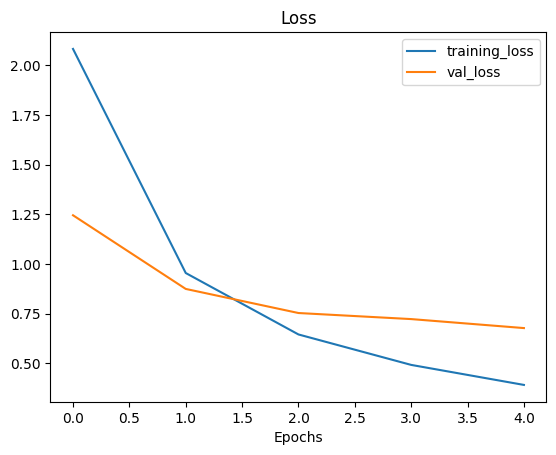

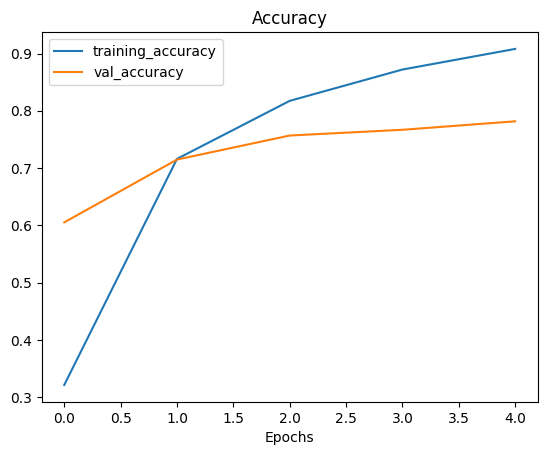

In [22]:
plot_loss_curves(resnet_history)

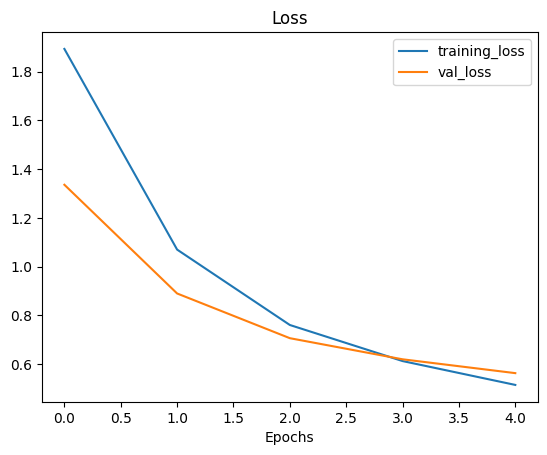

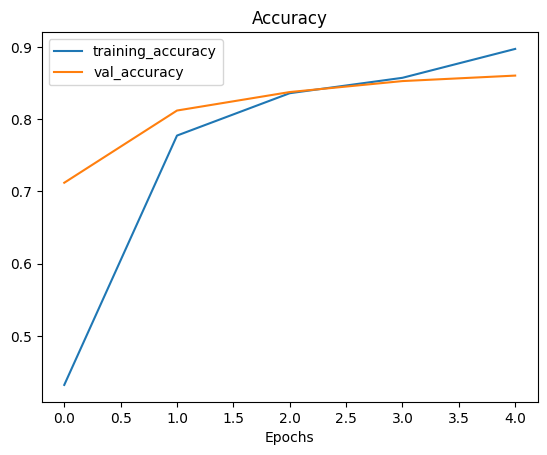

In [23]:
plot_loss_curves(efficientnet_history)

In [28]:
!tensorboard dev upload \
--logdir ./tensorflow_hub/ \
--name "EfficientNetB0 vs. ResNet50V2" \
--description "Comparing two different TF Hub feature extraction models architectues using 10% of training images" \
--one_shot 

2023-05-03 12:30:42.854381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   GWD-RCK-LLR

GWD-RCK-LLR


New experiment created. View your TensorBoard at: https://tensor

In [29]:
!tensorboard dev list

2023-05-03 12:34:21.212772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/k4wq0QxlSM2L00KvpYJVjg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectues using 10% of training images
	Id                   k4wq0QxlSM2L00KvpYJVjg
	Created              2023-05-03 12:32:55 (1 minute ago)
	Updated              2023-05-03 12:32:58 (1 minute ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5808578
Total: 1 experiment(s)


In [ ]:
#!tensorboard dev delete --experiment_id k4wq0QxlSM2L00KvpYJVjg